In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns

In [2]:
yelp = pd.read_json('./yelp_review_training_dataset.jsonl', lines=True)
yelp.head()

,review_id,text,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1


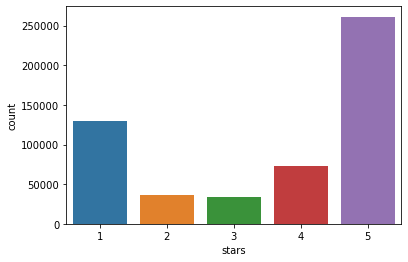

In [3]:
stars = yelp['stars'].values
ax = sns.countplot(x="stars",data=yelp)

In [4]:
yelp.shape

(533581, 3)

In [5]:
yelp[yelp.stars.notnull()]

,review_id,text,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1
...,...,...,...
533576,2vQO_kmSr6YPBrR8GH_FPA,Dr Young and her assistants take obvious pride...,5
533577,DUdLTGVpgsi0sv_g4A5ITQ,We started our 20 month of daughter here on an...,5
533578,AKGELpRNTTXajuZHbPxdJg,"First of all, they are supposed to open at 9:0...",2
533579,ghYZM7lqzjej05I_T3vYyA,It's not often that you visit a company and th...,5


In [6]:
x_train = yelp['text'].values

In [7]:
x_train[0]

'Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.'

In [8]:
import re
symbol = r'\w+|[^\s\w]+'
res = re.findall( symbol, x_train[0])
res

['Total',
 'bill',
 'for',
 'this',
 'horrible',
 'service',
 '?',
 'Over',
 '$',
 '8Gs',
 '.',
 'These',
 'crooks',
 'actually',
 'had',
 'the',
 'nerve',
 'to',
 'charge',
 'us',
 '$',
 '69',
 'for',
 '3',
 'pills',
 '.',
 'I',
 'checked',
 'online',
 'the',
 'pills',
 'can',
 'be',
 'had',
 'for',
 '19',
 'cents',
 'EACH',
 '!',
 'Avoid',
 'Hospital',
 'ERs',
 'at',
 'all',
 'costs',
 '.']

In [9]:
training = [re.findall( symbol, i) for i in x_train]

In [10]:
import numpy as np
training = np.array(training)

In [48]:
training = list(training)
first_part = round(len(training) * 0.1)
print(first_part)

53358


In [49]:
from gensim.models import Word2Vec
self_model = Word2Vec(training[:first_part], min_count=1)

In [50]:
training_sample = [[self_model.wv.key_to_index[word] for word in sentence] for sentence in training[:first_part]]


In [51]:
self_model.wv.index_to_key[0]

'.'

In [52]:
from sklearn.model_selection import train_test_split
y = np.array(stars[:first_part])
training_sample = np.array(training_sample)
train_x, val_x, train_y, val_y = train_test_split(training_sample, y, test_size=0.3, random_state=42)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [53]:

train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=maxlen)
val_x = keras.preprocessing.sequence.pad_sequences(val_x, maxlen=maxlen)

In [54]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 200
vocab_size = 200000

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(6, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)



In [55]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_x, train_y, batch_size=32, epochs=2, validation_data=(val_x, val_y)
)

Epoch 1/2
1168/1168 [==============================] - 302s 256ms/step - loss: 1.0718 - accuracy: 0.5999 - val_loss: 0.6825 - val_accuracy: 0.7322
Epoch 2/2
1168/1168 [==============================] - 282s 242ms/step - loss: 0.6123 - accuracy: 0.7639 - val_loss: 0.6903 - val_accuracy: 0.7260
